In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel

In [3]:
structures = pd.read_pickle("datasets/structures_defects.pickle.gzip")

In [4]:
def get_prediction_column(target):
  return f"predicted_{target}"

In [5]:
targets = {
  "homo": "models/MEGNet-defect-only/homo",
  #"formation_energy": "models/MEGNet-defect-only/defect_E",
  "energy_per_atom": "models/MEGNet-defect-only/E_per_atom"
}

In [6]:
for target, model_path in targets.items():
  model = MEGNetModel.from_file(model_path)
  prediction_column = get_prediction_column(target)
  structures.loc[:, prediction_column] = model.predict_structures(structures.defect_representation)

In [7]:
# TODO(kazeevn) pass structure as the global state
train, test = train_test_split(structures, test_size=0.25, random_state=42)
columns_to_save = ["_id"] + list(targets.keys()) + list(map(get_prediction_column, targets))
train.to_csv("datasets/predicted_dichalcogenides_innopolis_202105_v1/train.csv",
             columns=columns_to_save, index=False)
test.to_csv("datasets/predicted_dichalcogenides_innopolis_202105_v1/test.csv",
             columns=columns_to_save, index=False)

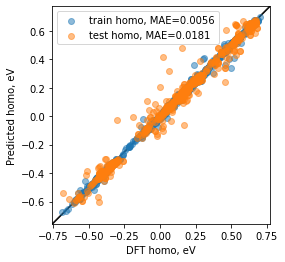

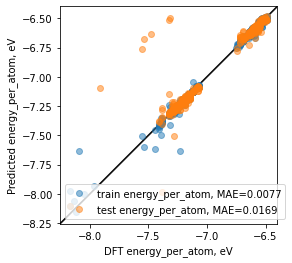

In [8]:
for target in targets.keys():
  fig, ax = plt.subplots()
  prediction_column = get_prediction_column(target)
  for name, data in (("train", train), ("test", test)):
    ax.scatter(data.loc[:, target], data.loc[:, prediction_column],
               label=f"{name} {target}, MAE="
               f"{np.mean(np.abs(data.loc[:, target]-data.loc[:, prediction_column])):.4f}",
               alpha=0.5)
    ax.set_xlabel(f"DFT {target}, eV")
    ax.set_ylabel(f"Predicted {target}, eV")
    ax.legend()

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
      ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims);